In [413]:
import numpy as np

import os
import inspect
import sys
import pandas as pd
import charts
import time
import math
import datetime

from opengrid.library import houseprint
from scipy.spatial import distance
from scipy.signal import butter, lfilter, freqz

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline
plt.rcParams['figure.figsize'] = 16,8

In [414]:
hp = houseprint.Houseprint()

Opening connection to Houseprint sheet
Opening spreadsheets
Parsing spreadsheets
34 Sites created
34 Devices created
97 sensors created
Houseprint parsing complete


In [415]:
device = hp.find_device('FL03001441')
device.get_sensors()

[
     Fluksosensor
     Key: 81fb589c911e808daa96a2064bebed41
     Type: electricity
     , 
     Fluksosensor
     Key: 212ce724e124fbde0fb649396375d099
     Type: gas
     , 
     Fluksosensor
     Key: c57f45b21e2ec21ab427f172478e1ca4
     Type: water
     , 
     Fluksosensor
     Key: 156e0abc64b00c5e98dbd3c17883b5f6
     Type: electricity
     , 
     Fluksosensor
     Key: e5306ee3a4235498592fc89ee0ede353
     Type: electricity
     ]

In [416]:
print pd.__version__

0.19.2


In [434]:
#Get Gas data
head = pd.Timestamp('20151110')
tail = pd.Timestamp('20151111')
electr = hp.find_sensor('212ce724e124fbde0fb649396375d099')
df_el = electr.get_data(head,tail,diff=True,resample='min',  unit='kW')
df_el_dropna = df_el.dropna()
df_el = pd.DataFrame(df_el)

In [418]:
if df_el.size <= 0:
    print "Dataframe is empty"
    
charts.plot(df_el.rolling(window=6,center=False).median(), show="inline", stock=True)

In [419]:
def znormalization(ts):
    """
    ts - each column of ts is a time series (np.ndarray)
    """
    mus = ts.mean(axis = 0)
    stds = ts.std(axis = 0)
    return (ts - mus) / stds

In [420]:
def paa_transform(ts, n_pieces):
    """
    ts: the columns of which are time series represented by e.g. np.array
    n_pieces: M equally sized piecies into which the original ts is splitted
    """
    splitted = np.array_split(ts, n_pieces) ## along columns as we want
    return np.asarray(map(lambda xs: xs.mean(axis = 0), splitted))

In [421]:
def sax_transform(ts, n_pieces, alphabet):
    """
    ts: columns of which are time serieses represented by np.array
    n_pieces: number of segments in paa transformation
    alphabet: the letters to be translated to, e.g. "abcd", "ab"
    return np.array of ts's sax transformation
    Steps:
    1. znormalize
    2. ppa
    3. find norm distribution breakpoints by scipy.stats
    4. convert ppa transformation into strings
    """
    from scipy.stats import norm
    alphabet_sz = len(alphabet)
    thrholds = norm.ppf(np.linspace(1./alphabet_sz, 
                                    1-1./alphabet_sz, 
                                    alphabet_sz-1))
    def translate(ts_values):
        return np.asarray([(alphabet[0] if ts_value < thrholds[0]
                else (alphabet[-1] if ts_value > thrholds[-1]
                      else alphabet[np.where(thrholds <= ts_value)[0][-1]+1]))
                           for ts_value in ts_values])
    paa_ts = paa_transform(znormalization(ts), n_pieces)
    return np.apply_along_axis(translate, 0, paa_ts)

In [422]:
def makeArray(array1):
    arrayValues=[]    
    for i in range(0, array1.size-1):
        if(i<array1.size):
             arrayValues.append(ord(array1.iloc[i])-97)
    df=pd.DataFrame(arrayValues)
    return df

In [423]:
def create_graph_from(df):
    list_with_graphs=[]
    list_with_graphs=pd.DataFrame(list_with_graphs)
    for i in range (0, df.index.size):
        list_with_graphs=list_with_graphs.append(df_el.ix[pd.Timestamp(df['start'][i]):pd.Timestamp(df['stop'][i])])
    return charts.plot(list_with_graphs, stock=True, show='inline')

In [424]:
def manhattanDistance2(s1,s2):
    dist = distance.cityblock(s1,s2)
    return dist

In [ ]:
def find_blocks(df_parent, row_parent, blocks, df_original, first_time = True):
    min_lvl = 0
    start = False
    
    block_start = 0
    block_end = 0
    
    nr_of_blocks_start = blocks.size
    
    nested = row_parent
    
    if first_time:
        start = True
        min_lvl = df_parent['repeatedValues'].min()
        
    #append last value again
    post_index = df_parent.index[-1] + pd.Timedelta(minutes=1)

    temp = pd.DataFrame(data=[df_parent.iloc[-1]], index=[post_index], columns=['repeatedValues'])
    df_parent = df_parent.append(temp)

    df_parent.sort_index(inplace=True)

    for i in range(1, df_parent.size - 1):
        if start == False and df_parent['repeatedValues'].iloc[i - 1] - df_parent['repeatedValues'].iloc[i] == 0:
            min_lvl = df_parent['repeatedValues'].iloc[i]
            start = True
        
        if start == True and df_parent['repeatedValues'].iloc[i] > min_lvl and df_parent['repeatedValues'].iloc[i - 1] == min_lvl:
            block_start = df_parent.index[i - 1]
            
        if start == True and block_start != 0 and df_parent['repeatedValues'].iloc[i] <= min_lvl:
            block_end = df_parent.index[i]
            
            #Match if the length is more than 10% less than the parent
            temp = pd.DataFrame(data=[[str(block_start), str(block_end), nested]], columns=['start', 'stop', 'nested_in'])
            
            if float(df_parent.index.size - df_parent.ix[block_start : block_end].index.size) / float(df_parent.index.size) > 0.10:
                if(block_end - block_start > pd.Timedelta(minutes=15)):
                    #print [block_start, block_end]
                    blocks = blocks.append(temp)
            
            df_parent2 = df_original.ix[block_start : block_end]
            row_parent = blocks.index.size - 1
            blocks = find_blocks(df_parent2, row_parent, blocks, df_original, False)
            blocks =  blocks.drop_duplicates(subset=['start', 'stop'], keep= 'first')
            block_start = 0
            block_end = 0
            
        if start == True and block_start == 0 and df_parent['repeatedValues'].iloc[i] < min_lvl:
            #Lvl dropped below min value so the min value was not assigned properly
            if df_parent['repeatedValues'].iloc[i+1] > df_parent['repeatedValues'].iloc[i]:
                
                #Match if the length is more than 10% less than the parent
                temp = pd.DataFrame(data=[[str(df_parent.index[0]), str(df_parent.index[i]), nested]], columns=['start', 'stop', 'nested_in'])
            
                if float(df_parent.index.size - df_parent.ix[df_parent.index[0] : df_parent.index[i]].index.size) / float(df_parent.index.size) > 0.10:
                    if(df_parent.index[i]-df_parent.index[0] > pd.Timedelta(minutes=15)):
                        #print [df_parent.index[i]-df_parent.index[0]]
                        blocks = blocks.append(temp)
                
                min_lvl = df_parent['repeatedValues'].iloc[i]
                
    
    return blocks

In [426]:
class MyValidationError(Exception):
    pass

In [427]:
def blockdetection(dataframe):
    
    if dataframe.size <= 0:
        raise MyValidationError("Dataframe must have a size bigger than 0")
    
        return None, None
    
    #Take the rolling mean to filter out peaks
    df_rm = dataframe.rolling(window=6,center=False).median()
    df_rm.index = df_rm.index - pd.Timedelta(minutes=3)
    df_rm = df_rm.dropna()
    
    #saxtransform
    saxTransmation = sax_transform(df_rm, df_rm.size/3, "abcdefghijklmnop")
    
    #Revert the letters to numbers
    letters=pd.DataFrame(saxTransmation)
    letters.columns=['col1']
    lettersToNumSax=makeArray(letters.col1) #Expects a pandaframe

    repeatedValues=np.repeat(lettersToNumSax.as_matrix(),3) #expects an array
    #make sure the dataframes are of the same length to join the data and the index
    shortage = df_rm.size - repeatedValues.size
    if shortage > 0:
        repeatedValues = np.append(repeatedValues, [repeatedValues[-1]]*shortage)

    elif shortage < 0:
        repeatedValues = repeatedValues[0:repeatedValues.size + shortage]
    
    shortage = df_rm.size - repeatedValues.size
    
    df_repeatedValues = pd.DataFrame(index=df_rm.index, data= repeatedValues, columns=['repeatedValues'])
    
    #pre- and append a zero to make sure the sample starts and ends with the same value
    for i in range(0, 2):
        pre_index = df_repeatedValues.index[0] - pd.Timedelta(minutes=1)
        post_index = df_repeatedValues.index[-1] + pd.Timedelta(minutes=1)

        temp = pd.DataFrame(data=[df_repeatedValues.min()], index=[pre_index], columns=['repeatedValues'])
        df_repeatedValues = df_repeatedValues.append(temp)

        temp = pd.DataFrame(data=[df_repeatedValues.min()], index=[post_index], columns=['repeatedValues'])
        df_repeatedValues = df_repeatedValues.append(temp)

        df_repeatedValues.sort_index(inplace=True)
    
    #Do the actual searching
    blocks = pd.DataFrame(columns=['start', 'stop', 'nested_in'])
    blocks = find_blocks(df_repeatedValues, -1, blocks, df_repeatedValues)
    
    #plot the dataframe with all the blocks
    fig, ax = plt.subplots()
    #ax.plot(df_repeatedValues.index, df_repeatedValues, color='grey')
    ax.plot(df_rm.index, df_rm, color='grey')

    colors = 100*['red', 'blue', 'orange', 'green', 'yellow']


    for i in range(0, blocks.index.size):
        ax.axvspan(blocks['start'].iloc[i], blocks['stop'].iloc[i], alpha=0.1, color=colors[3])
        #ax.axvspan(str(pd.Timestamp(blocks['start'].iloc[i])), str(pd.Timestamp(blocks['stop'].iloc[i]) + pd.Timedelta(minutes=2)), alpha=0.1, color=colors[3])
        #ax.axvspan(str(pd.Timestamp(blocks['start'].iloc[i])), str(pd.Timestamp(blocks['stop'].iloc[i])), alpha=0.1, color=colors[3])


    plt.show()
    
    #return the rolling mean equivalent and the blocks dataframe
    return df_rm, blocks
    
    

In [428]:
def sax_rm_shortage(dataframe):
    
    if dataframe.size <= 0:
        raise MyValidationError("Dataframe must have a size bigger than 0")
    
        return None, None
    
    #Take the rolling mean to filter out peaks
    df_rm = dataframe.rolling(window=6,center=False).median()
    df_rm.index = df_rm.index - pd.Timedelta(minutes=3)
    df_rm = df_rm.dropna()
    
    #saxtransform
    saxTransmation = sax_transform(df_rm, df_rm.size/3, "abcdefghijklmnop")
    
    #Revert the letters to numbers
    letters=pd.DataFrame(saxTransmation)
    letters.columns=['col1']
    lettersToNumSax=makeArray(letters.col1) #Expects a pandaframe

    repeatedValues=np.repeat(lettersToNumSax.as_matrix(),3) #expects an array
    #make sure the dataframes are of the same length to join the data and the index
    shortage = df_rm.size - repeatedValues.size
    if shortage > 0:
        repeatedValues = np.append(repeatedValues, [repeatedValues[-1]]*shortage)

    elif shortage < 0:
        repeatedValues = repeatedValues[0:repeatedValues.size + shortage]
    
    shortage = df_rm.size - repeatedValues.size
    
    df_repeatedValues = pd.DataFrame(index=df_rm.index, data= repeatedValues, columns=['repeatedValues'])
    return df_repeatedValues, df_rm
    

In [429]:
def blockdetection(df_repeatedValues, df_rm):
#pre- and append a zero to make sure the sample starts and ends with the same value
    for i in range(0, 2):
        pre_index = df_repeatedValues.index[0] - pd.Timedelta(minutes=1)
        post_index = df_repeatedValues.index[-1] + pd.Timedelta(minutes=1)

        temp = pd.DataFrame(data=[df_repeatedValues.min()], index=[pre_index], columns=['repeatedValues'])
        df_repeatedValues = df_repeatedValues.append(temp)

        temp = pd.DataFrame(data=[df_repeatedValues.min()], index=[post_index], columns=['repeatedValues'])
        df_repeatedValues = df_repeatedValues.append(temp)

        df_repeatedValues.sort_index(inplace=True)
    
    #Do the actual searching
    blocks = pd.DataFrame(columns=['start', 'stop', 'nested_in'])
    blocks = find_blocks(df_repeatedValues, -1, blocks, df_repeatedValues)
    
    #plot the dataframe with all the blocks
    fig, ax = plt.subplots()
    #ax.plot(df_repeatedValues.index, df_repeatedValues, color='grey')
    ax.plot(df_rm.index, df_rm, color='grey')

    colors = 100*['red', 'blue', 'orange', 'green', 'yellow']


    for i in range(0, blocks.index.size):
        #ax.axvspan(blocks['start'].iloc[i], blocks['stop'].iloc[i], alpha=0.1, color=colors[3])
        ax.axvspan(str(pd.Timestamp(blocks['start'].iloc[i])), str(pd.Timestamp(blocks['stop'].iloc[i]) + pd.Timedelta(minutes=2)), alpha=0.1, color=colors[3])
        #ax.axvspan(str(pd.Timestamp(blocks['start'].iloc[i])), str(pd.Timestamp(blocks['stop'].iloc[i])), alpha=0.1, color=colors[3])


    plt.show()
    
    #return the rolling mean equivalent and the blocks dataframe
    return df_rm, blocks

In [430]:
 def looping_through_list(df_with_values, array_to_compare):
    start=time.time()
    #Create list where values on which the different methods will act will be saved temporarily
    #This list will be cleared every time
    values_list=[]
    #Create list with results of the methods
    result_list=[]
    compare_to_array=np.array(array_to_compare)
    i=0 #Loops through list arrayToCompare.size times
    j=0 #Amount of values considered, and calculated.
    array_with_values=np.array(df_with_values)
    #start and stop timestamp
    starting_time_stamp=df_with_values.index[0]
    stop_time_stamp=df_with_values.index[array_to_compare.size-1]
    
    #Threshold
    threshold_value=array_to_compare.size/10
    #LOOPING THROUGH LIST
    while i < array_to_compare.size+j: #i is dependent on j, i updates as j updates.
        #Save x amount of values where x is the size of the array to compare.
        values_list.append(([array_with_values[i][0]]))
        i=i+1
        if(i==(array_to_compare.size+j)) and (i<(df_with_values.size)):
            #j = the minute at this moment. i = starting from the current minute, adding the size of the array to compare.
            #Stops running when the limit of values to be considered is reached, being the size the original array.
            if(j==0) or (manhattanDistance2(compare_to_array,values_list)!=result_list[len(result_list)-1][0]):
                #Create list with unique values. Save them in "resultList". Euclidean score, startTimestamp, stopTimestamp
                result_list.append([manhattanDistance2(compare_to_array,values_list), starting_time_stamp,stop_time_stamp]) 
            j=j+1
            starting_time_stamp=df_with_values.index[j] #startingTimeStamp: current minute considered
            stop_time_stamp=df_with_values.index[i] #stopTimeStamp: current minute considered + size of array to compare.
            i=j
            values_list=[]
    print time.time()-start
    return result_list

In [431]:
 def local_minima_ts_correction(result_list):
    start=time.time()
    loop_index=0 #Loops throu"gh the resultslist, as long as its size
    current_saves=0 #Current amount of variables saved
    some_list=[]
    df_result=pd.DataFrame(some_list)
    ts=(list_view[0][2]-list_view[0][1])/10
    threshold_value=(ts / np.timedelta64(1, 'm')).astype(int)
    #SAVING ONLY RELEVANT VALUES       
    while loop_index < len(result_list):
        if(loop_index==0):
            [value,start_time_stamp,stop_time_stamp] = [result_list[loop_index][0], result_list[loop_index][1], result_list[loop_index][2]]
            df_result=df_result.append(pd.DataFrame([[value, start_time_stamp,stop_time_stamp]], index=[current_saves], columns=['Manhattan','startTimeStamp','stopTimeStamp']))
            current_saves=current_saves+1
        if(result_list[loop_index-1][0] < result_list[loop_index-2][0]) and (result_list[loop_index-1][0] < result_list[loop_index][0]) and result_list[loop_index-1][0] < df_result.max()['Manhattan']:
            #print "Value", resultList[loopIndex-1][0],",Index:",loopIndex-1,"has a lower value than value left and right to it.(",resultList[loopIndex-2][0],",",resultList[loopIndex][0],") nIt will now replace", dfResult['Euclidean'].max(),"in the dataset."
            [value,start_time_stamp,stop_time_stamp] = [result_list[loop_index-1][0], result_list[loop_index-1][1], result_list[loop_index-1][2]]
            list_with_values=[]
            i=0
            max_value=0
            #!!!Timestamps are important. If timestamp is within the range of another timestamp already present,
            #they will overwrite eachother instead of adding a new unique value
            while i < df_result.index.size:
                if(start_time_stamp >= df_result['startTimeStamp'][i]) and (start_time_stamp <= df_result['stopTimeStamp'][i]-pd.Timedelta(minutes=threshold_value)):
                    #INSIDE BOUNDARIES
                    if(df_result.loc[i][0] > max_value) and (df_result.loc[i][0]!=0): #Store the maximum value, of the range between start and stoptimestamp.
                        max_value=df_result.loc[i][0]
                        ts=df_result.loc[i][1]
                    elif(df_result.loc[i][0]==0): #PERFECT MATCH
                        max_value=1 #Not 0 because otherwise we assume it is outside of the boundaries
                i=i+1
            if(max_value==0): 
                #OUTSIDE BOUNDARIES
                    df_result=df_result.append(pd.DataFrame([[value, start_time_stamp,stop_time_stamp]], index=[current_saves], columns=['Manhattan','startTimeStamp','stopTimeStamp']))
                    current_saves=current_saves+1
                #INSIDE BOUNDARIES - 
            elif(value < max_value): #Check if the current value is smaller than the Maximum value encountered. Replace if it is.
                    df_result.loc[df_result['Manhattan']== max_value] = [value, start_time_stamp, stop_time_stamp]
        loop_index=loop_index+1
    df_result=df_result.sort_values(['Manhattan'])
    print time.time()-start
    return df_result
        

In [432]:
def calculate_threshold_value(df_result, nr_of_best_values, factor):
    list_of_best_values=[]
    i = 0
    for i in range(0, nr_of_best_values):
        list_of_best_values.append(df_result.iloc[i])
    list_of_best_values=pd.DataFrame(list_of_best_values)
    mean=list_of_best_values.mean()
    threshold=mean*factor
    print threshold
    return df_result.loc[df_result['Manhattan']<=threshold[0]]
    

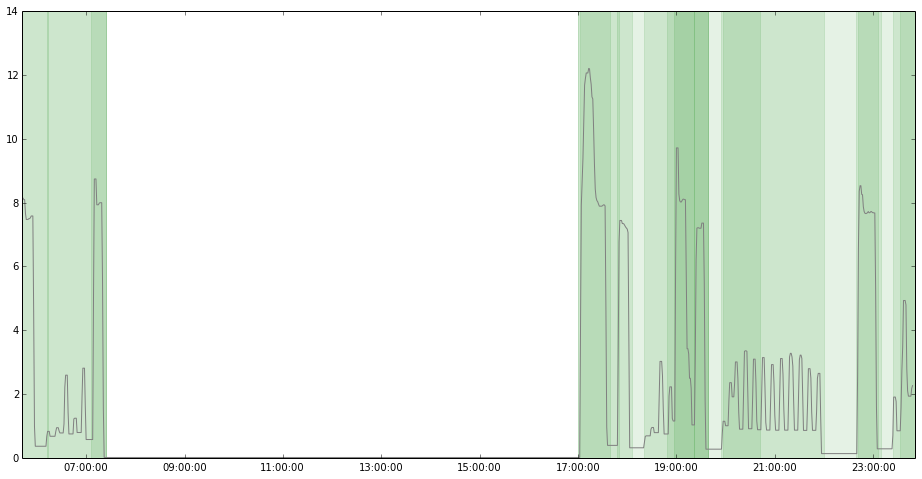

In [436]:
try:
    frame, df_rm=sax_rm_shortage(df_el)
    originalrm, blocks = blockdetection(frame, df_rm)
    
except MyValidationError as exception:
    # handle exception here and get error message
    print exception

<h4> Indexing dataframe </h4>

In [437]:
blocks.reset_index(drop=True, inplace=True)

In [438]:
blocks

,start,stop,nested_in
0,2015-11-10 05:42:00+00:00,2015-11-10 07:22:00+00:00,-1.0
1,2015-11-10 05:42:00+00:00,2015-11-10 06:12:00+00:00,0.0
2,2015-11-10 06:12:00+00:00,2015-11-10 07:22:00+00:00,0.0
3,2015-11-10 07:06:00+00:00,2015-11-10 07:22:00+00:00,2.0
4,2015-11-10 17:00:00+00:00,2015-11-10 23:49:00+00:00,-1.0
5,2015-11-10 17:03:00+00:00,2015-11-10 17:37:00+00:00,4.0
6,2015-11-10 17:00:00+00:00,2015-11-10 17:48:00+00:00,4.0
7,2015-11-10 17:48:00+00:00,2015-11-10 18:04:00+00:00,4.0
8,2015-11-10 18:21:00+00:00,2015-11-10 19:37:00+00:00,4.0
9,2015-11-10 18:48:00+00:00,2015-11-10 19:37:00+00:00,8.0


<h4> indexing and creating list of blocks with '-1' index <h/4>

In [282]:
list_blocks=[]
list_blocks=pd.DataFrame(list_blocks)

for i in range (0, blocks.index.size):
    if(blocks['nested_in'][i] == -1.0):
        list_blocks=list_blocks.append((blocks.iloc[i]))

In [283]:
# dfblocks = [1]
# dfblocks=pd.DataFrame(dfblocks,index=[0])
# for i in range (1,len(list_blocks)):
#     dfblocks=dfblocks.append(pd.DataFrame([i], index=[i]))

In [284]:
def find_big_blocks(list_of_blocks):
    list_blocks=[]
    for i in range(0, list_of_blocks.index.size):
        if(blocks['nested_in'][i] == -1.0):
            list_blocks.append(list_of_blocks.iloc[i])
    list_blocks=pd.DataFrame(list_blocks)
    list_blocks.reset_index(drop=True, inplace=True)
    return list_blocks

<h4> visualisation of original frames found by block detection </h4>

In [285]:
# create_graph_from(list_blocks)

In [286]:
# df_el.ix[pd.Timestamp(list_blocks['start'][0]):pd.Timestamp(list_blocks['stop'][0])]

<h4> Loop through indexes and calculate score </h4>

<h3> looping begins </h3>

In [333]:
 def looping_through_list(df_with_values, array_to_compare):
    start=time.time()
    #Create list where values on which the different methods will act will be saved temporarily
    #This list will be cleared every time
    values_list=[]
    #Create list with results of the methods
    result_list=[]
    compare_to_array=np.array(array_to_compare)
    i=0 #Loops through list arrayToCompare.size times
    j=0 #Amount of values considered, and calculated.
    array_with_values=np.array(df_with_values)
    #start and stop timestamp
    starting_time_stamp=df_with_values.index[0]
    stop_time_stamp=df_with_values.index[array_to_compare.size-1]
    #Threshold
    threshold_value=array_to_compare.size/10
    #LOOPING THROUGH LIST
    if(array_to_compare.index.size != df_with_values.index.size):
        while i < array_to_compare.size+j: #i is dependent on j, i updates as j updates.
            #Save x amount of values where x is the size of the array to compare.
            values_list.append(([array_with_values[i][0]]))
            i=i+1
            if(i==(array_to_compare.size+j)) and (i<(df_with_values.size)):
                #print df_with_values.size
                #j = the minute at this moment. i = starting from the current minute, adding the size of the array to compare.
                #Stops running when the limit of values to be considered is reached, being the size the original array.
                if(j==0) or (manhattanDistance2(compare_to_array,values_list)!=result_list[len(result_list)-1][0]):
                    #Create list with unique values. Save them in "resultList". Euclidean score, startTimestamp, stopTimestamp
                    result_list.append([manhattanDistance2(compare_to_array,values_list), starting_time_stamp,stop_time_stamp])     
                j=j+1
                starting_time_stamp=df_with_values.index[j] #startingTimeStamp: current minute considered
                stop_time_stamp=df_with_values.index[array_to_compare.size+j-1] #stopTimeStamp: current minute considered + size of array to compare.
                #Storing last stop_time_stamp
                if(array_to_compare.size+j-1 == df_with_values.size-1):
                    result_list.append([manhattanDistance2(compare_to_array,values_list), starting_time_stamp,stop_time_stamp])     
                i=j
                values_list=[]
    else:
        print "in here"
        result_list.append([manhattanDistance2(compare_to_array,df_with_values), starting_time_stamp,stop_time_stamp])     
    return result_list

In [288]:
list_blocks['Type']=1
for i in range(0, list_blocks.index.size):
    list_blocks['Type'][i] = list_blocks.index[i]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [289]:
blocks['Type']=1
k=0
for i in range(0, blocks.index.size):
    if(blocks['nested_in'][i]==-1.0):
        j = 0
        blocks['Type'][i] = blocks.index[i]
        k=i
    else:
#         print blocks.index[k],"",j
        blocks['Type'][i] = blocks.index[k],".. ",j
        j=j+1

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [290]:
# #Get Gas data
# head = pd.Timestamp('20151110')
# tail = pd.Timestamp('20151118')
# electr = hp.find_sensor('212ce724e124fbde0fb649396375d099')
# df_el = electr.get_data(head,tail,diff=True,resample='min',  unit='kW')
# df_el_dropna = df_el.dropna()
# df_el = pd.DataFrame(df_el)

In [291]:
# def looping_through_list_original(df_list_blocks):
#     start_time = time.time()
#     time_now = time.time()
#     #Create list of costs
#     cost_list = []
#     #Creating variable 'j'. This will make sure we don't check the same frames twice.
#     j=0
#     #Other variable
#     k=0
#     for i in range(0, df_list_blocks.index.size):
#         start = df_list_blocks.iloc[i][0]
#         stop = df_list_blocks.iloc[i][1]
#         #This will create a dataframe with all the values between the start and stop timestamp.
#         #This is used for comparing these values using a similarity algorithm with the others
#         df_original = df_el.ix[pd.Timestamp(start):pd.Timestamp(stop)]
#         type_original = df_list_blocks.iloc[i][3]
#         print type_original
#         if(k==1):
#             print "After type: ", j, "we will raise 'j' so that the next type ", j+1, "won't be compared again with type ", j
#             j=j+1
#         for i in range(j, df_list_blocks.index.size):
#             df_new = df_el.ix[pd.Timestamp(df_list_blocks.iloc[i][0]):pd.Timestamp(df_list_blocks.iloc[i][1])]
#             if(df_new.index.size > df_original.index.size):
# #                 print "looping"
#                 result = looping_through_list(df_new, df_original)
#                 if(min(result)[0] not in [row[0][0] for row in cost_list]):
#                     cost_list.append((min(result), ('Original: Type', type_original, 'against type', df_list_blocks.iloc[i][3])))
#             elif(df_new.index.size < df_original.index.size):
# #                 print "looping"
#                 result = looping_through_list(df_original, df_new)
#                 if(min(result)[0] not in [row[0][0] for row in cost_list]):
#                     cost_list.append((min(result), ('Substitute: Type', df_list_blocks.iloc[i][3], 'against original type', type_original)))
#             k=1
#     print  "Time to complete: ", time.time() - start_time
#     return cost_list

In [292]:
# list_view = looping_through_list_original(list_blocks)

In [293]:
def create_dataframe(list_view):
    df_list_view=[]
    df_list_view=pd.DataFrame(df_list_view)

    df_substitutes=[]
    df_substitutes=pd.DataFrame(df_substitutes)
    for i in range(0, len(list_view)):
        if(list_view[i][1][0] == 'Substitute: Type'):
            df_substitutes = df_substitutes.append(pd.DataFrame([[list_view[i][0][0],list_view[i][0][1],list_view[i][0][2], list_view[i][1]]], columns=['Manhattan', 'start', 'stop', 'Frame'], index=[i]))
        else:       
            df_list_view = df_list_view.append(pd.DataFrame([[list_view[i][0][0],list_view[i][0][1],list_view[i][0][2], list_view[i][1]]], columns=['Manhattan', 'start', 'stop', 'Frame'], index=[i]))
    return df_substitutes, df_list_view

In [308]:
test = df_el.ix[pd.Timestamp(blocks.iloc[0][0]):pd.Timestamp(blocks.iloc[0][1])]
test_2 = df_el.ix[pd.Timestamp(blocks.iloc[1][0]):pd.Timestamp(blocks.iloc[1][1])]
i=1
if(i==1) and not(test.equals(test_2)):
    print "false"


false


In [311]:
list_big_blocks

,start,stop,nested_in,Type
0,2015-11-10 05:42:00+00:00,2015-11-10 07:22:00+00:00,-1.0,0
1,2015-11-10 17:00:00+00:00,2015-11-10 21:55:00+00:00,-1.0,4
2,2015-11-10 22:36:00+00:00,2015-11-11 05:28:00+00:00,-1.0,14
3,2015-11-11 06:09:00+00:00,2015-11-11 14:04:00+00:00,-1.0,21
4,2015-11-11 18:21:00+00:00,2015-11-11 21:58:00+00:00,-1.0,41
5,2015-11-12 05:27:00+00:00,2015-11-12 06:58:00+00:00,-1.0,48
6,2015-11-12 09:57:00+00:00,2015-11-12 13:25:00+00:00,-1.0,50
7,2015-11-12 18:54:00+00:00,2015-11-12 21:58:00+00:00,-1.0,60
8,2015-11-13 05:30:00+00:00,2015-11-13 06:55:00+00:00,-1.0,68
9,2015-11-13 16:27:00+00:00,2015-11-13 22:13:00+00:00,-1.0,73


In [336]:
def looping_through_list_original(df_list_blocks):
    start_time = time.time()
    time_now = time.time()
    #Create list of costs
    cost_list = []
    #Crating variable 'j'. This will make sure we don't check the same frames twice.
    j=1
    #Other variable
    k=0
    for i in range(0, df_list_blocks.index.size):
        start = df_list_blocks.iloc[i][0]
        stop = df_list_blocks.iloc[i][1]
        #This will create a dataframe with all the values between the start and stop timestamp.
        #This is used for comparing these values using a similarity algorithm with the others
        df_original = df_el.ix[pd.Timestamp(start):pd.Timestamp(stop)]
        #Type of the block
        type_original = df_list_blocks.iloc[i][3]
        #Original or nested in
        original_or_nested = df_list_blocks.iloc[i][2]
        #get the big blocks
        df_list_big_blocks = find_big_blocks(df_list_blocks)
        nr_loops=0
        print type_original
        if(k==1) and (original_or_nested == -1.0):
            j=j+1
        for i in range(j, df_list_big_blocks.index.size):
            df_new = df_el.ix[pd.Timestamp(df_list_big_blocks.iloc[i][0]):pd.Timestamp(df_list_big_blocks.iloc[i][1])]
            if(df_new.index.size >= df_original.index.size) and not(df_new.equals(df_original)) :
                nr_loops=nr_loops+1
                print "looping: ", nr_loops
                result = looping_through_list(df_new, df_original)
                if(min(result)[0] not in [row[0][0] for row in cost_list]):
                    cost_list.append((min(result), ('Original: Type', type_original, 'against type', df_list_big_blocks.iloc[i][3])))
            elif(df_new.index.size < df_original.index.size):
                nr_loops=nr_loops+1                
                print "looping: ", nr_loops
                result = looping_through_list(df_original, df_new)
                if(min(result)[0] not in [row[0][0] for row in cost_list]):
                    cost_list.append((min(result), ('Substitute: Type', df_list_big_blocks.iloc[i][3], 'against original type', type_original)))
            k=1
    print  "Time to complete: ", time.time() - start_time
    return cost_list

In [337]:
list_view = looping_through_list_original(blocks)

0
looping:  1
looping:  2
looping:  3
looping:  4
looping:  5
looping:  6
looping:  7
looping:  8
looping:  9
looping:  10
looping:  11
looping:  12
looping:  13
looping:  14
looping:  15
looping:  16
looping:  17
looping:  18
looping:  19
looping:  20
(0, '.. ', 0)
looping:  1
looping:  2
looping:  3
looping:  4
looping:  5
looping:  6
looping:  7
looping:  8
looping:  9
looping:  10
looping:  11
looping:  12
looping:  13
looping:  14
looping:  15
looping:  16
looping:  17
looping:  18
looping:  19
looping:  20
(0, '.. ', 1)
looping:  1
looping:  2
looping:  3
looping:  4
looping:  5
looping:  6
looping:  7
looping:  8
looping:  9
looping:  10
looping:  11
looping:  12
looping:  13
in here
looping:  14
looping:  15
looping:  16
looping:  17
looping:  18
looping:  19
looping:  20
(0, '.. ', 2)
looping:  1
looping:  2
looping:  3
looping:  4
looping:  5
looping:  6
looping:  7
looping:  8
looping:  9
looping:  10
looping:  11
looping:  12
looping:  13
in here
looping:  14
looping:  15
l

In [338]:
df_substitutes, df_list_view = create_dataframe(list_view)

In [339]:
df_list_view

,Manhattan,start,stop,Frame
0,190.210508,2015-11-10 19:20:00+00:00,2015-11-10 21:00:00+00:00,"(Original: Type, 0, against type, 4)"
1,170.622798,2015-11-10 22:49:00+00:00,2015-11-11 00:29:00+00:00,"(Original: Type, 0, against type, 14)"
2,174.342257,2015-11-11 11:08:00+00:00,2015-11-11 12:48:00+00:00,"(Original: Type, 0, against type, 21)"
3,156.209465,2015-11-11 18:44:00+00:00,2015-11-11 20:24:00+00:00,"(Original: Type, 0, against type, 41)"
5,188.164936,2015-11-12 10:36:00+00:00,2015-11-12 12:16:00+00:00,"(Original: Type, 0, against type, 50)"
6,241.379559,2015-11-12 19:51:00+00:00,2015-11-12 21:31:00+00:00,"(Original: Type, 0, against type, 60)"
8,243.770885,2015-11-13 18:31:00+00:00,2015-11-13 20:11:00+00:00,"(Original: Type, 0, against type, 73)"
10,214.883186,2015-11-14 19:24:00+00:00,2015-11-14 21:04:00+00:00,"(Original: Type, 0, against type, 91)"
11,451.795791,2015-11-15 06:12:00+00:00,2015-11-15 07:52:00+00:00,"(Original: Type, 0, against type, 117)"
13,214.746963,2015-11-15 19:55:00+00:00,2015-11-15 21:35:00+00:00,"(Original: Type, 0, against type, 122)"


In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', 6):
    print df_list_view

In [340]:
df_list_sorted = df_list_view.sort_values('Manhattan')
df_substitutes_sorted = df_substitutes.sort_values('Frame')

In [342]:
blocks

,start,stop,nested_in,Type
0,2015-11-10 05:42:00+00:00,2015-11-10 07:22:00+00:00,-1.0,0
1,2015-11-10 05:42:00+00:00,2015-11-10 06:09:00+00:00,0.0,"(0, .. , 0)"
2,2015-11-10 06:21:00+00:00,2015-11-10 06:37:00+00:00,0.0,"(0, .. , 1)"
3,2015-11-10 06:42:00+00:00,2015-11-10 06:58:00+00:00,0.0,"(0, .. , 2)"
4,2015-11-10 17:00:00+00:00,2015-11-10 21:55:00+00:00,-1.0,4
5,2015-11-10 17:00:00+00:00,2015-11-10 17:45:00+00:00,4.0,"(4, .. , 0)"
6,2015-11-10 17:45:00+00:00,2015-11-10 18:01:00+00:00,4.0,"(4, .. , 1)"
7,2015-11-10 18:24:00+00:00,2015-11-10 18:43:00+00:00,4.0,"(4, .. , 2)"
8,2015-11-10 18:48:00+00:00,2015-11-10 19:34:00+00:00,4.0,"(4, .. , 3)"
9,2015-11-10 18:54:00+00:00,2015-11-10 19:16:00+00:00,8.0,"(4, .. , 4)"


In [341]:
df_list_sorted

,Manhattan,start,stop,Frame
1313,2.554667,2015-11-17 20:17:00+00:00,2015-11-17 20:42:00+00:00,"(Original: Type, (73, .. , 14), against type, ..."
42,3.448923,2015-11-11 06:42:00+00:00,2015-11-11 06:58:00+00:00,"(Original: Type, (0, .. , 1), against type, 21)"
62,4.306231,2015-11-11 06:42:00+00:00,2015-11-11 06:58:00+00:00,"(Original: Type, (0, .. , 2), against type, 21)"
547,4.608900,2015-11-14 19:59:00+00:00,2015-11-14 20:15:00+00:00,"(Original: Type, (21, .. , 8), against type, 91)"
564,5.408682,2015-11-14 18:28:00+00:00,2015-11-14 18:44:00+00:00,"(Original: Type, (21, .. , 9), against type, 91)"
812,5.410658,2015-11-12 18:57:00+00:00,2015-11-12 19:13:00+00:00,"(Original: Type, (41, .. , 5), against type, 60)"
1681,5.540813,2015-11-17 18:18:00+00:00,2015-11-17 18:36:00+00:00,"(Original: Type, (137, .. , 3), against type, ..."
60,5.598574,2015-11-10 18:26:00+00:00,2015-11-10 18:42:00+00:00,"(Original: Type, (0, .. , 2), against type, 4)"
33,6.546024,2015-11-15 16:45:00+00:00,2015-11-15 17:12:00+00:00,"(Original: Type, (0, .. , 0), against type, 122)"
40,6.612054,2015-11-10 18:27:00+00:00,2015-11-10 18:43:00+00:00,"(Original: Type, (0, .. , 1), against type, 4)"


In [350]:
df_2 = df_el.ix[pd.Timestamp(df_list_sorted['start'][2]):pd.Timestamp(df_list_sorted['stop'][2])]
df_1 = df_el.ix[pd.Timestamp(blocks['start'][2]):pd.Timestamp(blocks['stop'][2])]

In [351]:
df_list_sorted['start'][2]

Timestamp('2015-11-11 06:42:00+0000', tz='UTC')

In [352]:
manhattanDistance2(df_1, df_2)

3.4489234403357849

In [354]:
df_concat=pd.concat([df_2,df_1])
charts.plot(df_1, stock=True, show='inline')